In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import os
import pickle

import multiprocessing

n_cores = multiprocessing.cpu_count() - 2

In [11]:
names = ['ID', 'Xcor','Ycor', 'F606','eF606','F814','eF814','chi','sharp']
df_stars = pd.read_csv('../Data/hlsp_deep47tuc_hst_acs_47tuc_f606w-f814w_v1_catalog.txt', 
                      names=names, delim_whitespace=True, skiprows=1)

df_stars['Label'] = 1
df_stars.loc[df_stars.sharp < 0, 'Label'] = 0
df_stars.loc[df_stars.sharp > 0, 'Label'] = 2

df_stars.head()

ID      Xcor     Ycor    F606   eF606    F814   eF814     chi   sharp  \
0    8  4462.947  140.859  28.197  0.1036  27.127  0.1068   6.106  0.7310   
1  120  5002.486  186.138  20.843  0.0552  19.815  0.0661  10.690  0.4000   
2  165  5003.574  195.421  27.014  0.2194  26.068  0.1349  10.651  0.1940   
3  226  4448.493  207.417  30.193  0.3641  28.270  0.1636   4.059 -1.9585   
4  351  5040.717  224.366  28.935  0.1669  28.941  0.2464   4.274 -0.7720   

   Label  
0      2  
1      2  
2      2  
3      0  
4      0

# Visualize Data

(33.0, 12.0)

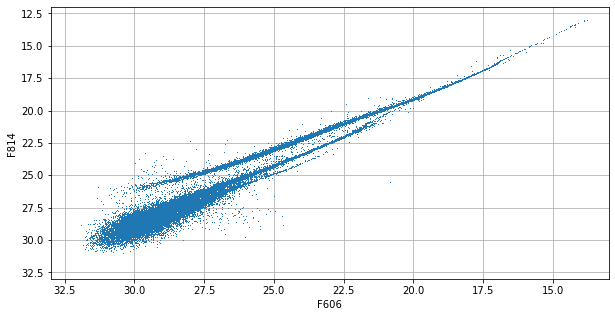

In [12]:
plt.figure(figsize=(10,5))
plt.plot(df_stars.F606, df_stars.F814, ',')
plt.xlabel('F606')
plt.ylabel('F814')
plt.grid()
plt.xlim(33, 13)
plt.ylim(33, 12)

# Splitting the dataset into train and test samples 

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale

x_preprocessed = minmax_scale(X=df_stars.iloc[:, :-2].values)
x_train, x_test, y_train, y_test = train_test_split(x_preprocessed, df_stars.Label.values)

# Grid Search and Cross Validation process
## Random Forest Classifier and Grid Search

In [19]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier

if not(os.path.isfile("../Model_best_parameters/best_parameters_DT.p")):
    grid_param_DT = {'n_estimators': [100, 300, 500, 800, 1000],
                     'criterion': ['gini', 'entropy']
                    }

    model_DT = ExtraTreesClassifier()

    gs_src_DT = GridSearchCV(estimator=model_DT, 
                 param_grid=grid_param_DT,
                 scoring='accuracy',
                 cv=10,
                 n_jobs=-1)

    gs_src_DT.fit(x_train, y_train)
    best_parameters = gs_src_DT.best_params_
    
    pickle.dump(best_parameters, open("../Model_best_parameters/best_parameters_DT.p", "wb"))

    importances = model_DT.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model_DT.estimators_], axis=0)

    forest_importances = pd.Series(importances, index=df_stars.columns[:-2])

    fig, ax = plt.subplots(figsize=(16,9))
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
else:
    DT_param = pickle.load(open("../Model_best_parameters/best_parameters_DT.p", 'rb'))
    
    model_DT = ExtraTreesClassifier(**DT_param)
    model_DT.fit(X=x_train, y=y_train)

    std = np.std([tree.feature_importances_ for tree in model_DT.estimators_], axis=0)

    forest_importances = pd.DataFrame({'Importances': model_DT.feature_importances_, 
                                       'Std': std}, index=df_stars.columns[:-2])

    forest_importances.sort_values(by='Importances', ascending=False, inplace=True)

    fig, ax = plt.subplots(figsize=(16,9))
    forest_importances.Importances.plot.bar(yerr=forest_importances.Std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()

In [ ]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score


scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score, average='micro'),
           'recall' : make_scorer(recall_score, average='micro'), 
           'f1_score' : make_scorer(f1_score, average='micro')}

model_DT = ExtraTreesClassifier(**DT_param)

cross_validate(estimator=model_DT, X=x_train, y=y_train, cv=n_cores, scoring=scoring, n_jobs=n_cores)

NameError: name 'ExtraTreesClassifier' is not defined

## Support Vector Classifier Grid Search

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

if not(os.path.isfile("../Model_best_parameters/best_parameters_svm.p")):
    grid_param_SVM = {'C': [0.1, 1, 10, 100],
                      'kernel': ['poly', 'rbf']
                     }

    model_SVM = SVC(class_weight='balanced')


    gs_src_svm = GridSearchCV(estimator=model_SVM, 
                 param_grid=grid_param_SVM,
                 scoring='accuracy',
                 cv=10,
                 n_jobs=-1)

    gs_src_svm.fit(x_train, y_train)
    
    best_parameters_SVM = gs_src_svm.best_params_
    best_parameters_SVM
    
    pickle.dump(best_parameters, open("../Model_best_parameters/best_parameters_svm.p", "wb"))
else: 
    SVM_param = pickle.load(open("../Model_best_parameters/best_parameters_svm.p", "rb"))

In [ ]:
model_SVM = SVC(**SVM_param, class_weight='balanced')

cross_validate(estimator=model_SVM, X=x_train, y=y_train, cv=n_cores, scoring=scoring, n_jobs=n_cores)

{'fit_time': array([35.32887387, 38.50160217, 38.65168285, 38.89303303, 36.00714707,
        38.90040612]),
 'score_time': array([7.13591623, 6.58153176, 6.76516795, 6.68200803, 7.23486304,
        6.615942  ]),
 'test_accuracy': array([0.76891997, 0.75384615, 0.75990676, 0.76239316, 0.77016317,
        0.76721057]),
 'test_precision': array([0.76891997, 0.75384615, 0.75990676, 0.76239316, 0.77016317,
        0.76721057]),
 'test_recall': array([0.76891997, 0.75384615, 0.75990676, 0.76239316, 0.77016317,
        0.76721057]),
 'test_f1_score': array([0.76891997, 0.75384615, 0.75990676, 0.76239316, 0.77016317,
        0.76721057])}

In [ ]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=3).fit(X=x_train, y=y_train)

cross_validate(estimator=gm, X=x_train, y=y_train, cv=n_cores, scoring=scoring, n_jobs=n_cores)